(backus-averaging-page)=
# Backus Averaging

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from numpy import pi, sin, cos, sqrt

In [2]:
%matplotlib inline

plt.show()

In [3]:
plt.rcParams.update({'lines.linewidth': 2.0, 'figure.figsize': [8.0, 5.0],
                     'axes.grid' : True, 'grid.linestyle': ":", 'grid.alpha': 0.7, 'lines.markersize': 5})

COLOR_ax = [0.15,0.15,0.15]
mpl.rcParams['text.color'] = COLOR_ax
mpl.rcParams['axes.labelcolor'] = COLOR_ax
mpl.rcParams['xtick.color'] = COLOR_ax
mpl.rcParams['ytick.color'] = COLOR_ax

colorlist_Iceland = np.array([[5, 100, 113], [253, 170, 0], [80, 63, 88], [134, 172, 25], [76, 166, 193], [157, 110, 51], [43, 63, 85]])/255.0
# colorlist_Iceland = np.array([[50, 70, 110], [150, 192, 25], [157, 110, 51], [5, 100, 113], [80, 63, 88], [76, 166, 193], [253, 170, 0]])/255.0
colorlist_Iceland = np.array([[50, 70, 110], [203, 150, 0], [157, 110, 51], [134, 172, 25], [76, 166, 193], [157, 110, 51], [43, 63, 85]])/255.0

colorlist_Iceland = ['#377eb8', '#ff7f00', '#4daf4a', '#984ea3']
colorlist_Iceland = ['#32466e', '#FFA024', '#96c019', '#bb5566', '#44aa99', '#88ccee', '#ffcccc']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color = colorlist_Iceland) 

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Introduction 🎍

This page is devoted to a special technique of elastic rock properties averaging. It is named after G.E. Backus who first introduced it in [1962](https://doi.org/10.1029/JZ067i011p04427).

This method implies a model of a finely layered rock formation. Due to seismic resolution limitations, we normally cannot 'see' individual thin layers. Instead, we tend to think of this formation as of a homogeneous rock with certain average properties. Backus averaging allows us to compute these average parameters given the properties of individial thin layers.

This task is often referred to as **'upscaling'**. A layered model can be up-scaled to a transverse isotropic 'averaged' medium (we normally call it '**effective medium**').



:::{seealso}

- [G.E. Backus, "Long-wave elastic anisotropy produced by horizontal layering", J.Geoph.Res., 1962](https://doi.org/10.1029/JZ067i011p04427)
- [D. Kumar, "Applying Backus averaging for deriving seismic anisotropy...", J.Geoph.Eng, 2013](https://doi.org/10.1088/1742-2132/10/5/055001)
- [SEGWiki: Transverse isotropy / Backus upscaling](https://wiki.seg.org/wiki/Dictionary:Transverse_isotropy#Backus_upscaling_.28Long_wavelength_approximation.29)
- [C. Liner, T. Fei, "The Backus number", The Leading Edge, 2007](https://library.seg.org/doi/abs/10.1190/1.2723204)
- [L. Thomsen, "Understanding seismic anisotropy in exploration and exploitation", SEG DISC 2014](https://library.seg.org/doi/pdf/10.1190/1.9781560801986) / see Appendix IIC (page S-14), 
- [J. Berryman, V. Grechka, P. Berge, "Analysis of Thomsen parameters for finely layered VTI media", SEP, 1997](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.6.6858&rep=rep1&type=pdf)

:::

## Objectives 🎯

1. Maths
2. Test averaging on a portion of rock
3. Stochastically simulate a set of layered rocks
4. Apply averaging to well logs using rolling window


## Maths 📓

### Relations between stiffness, velocities and anisotropy

Recall the VTI stiffness matrix in Voigt notation:

> $$C^{VTI} = \begin{bmatrix} 
C_{11}         & C_{11}-2C_{66} & C_{13} & 0 & 0 & 0 \\ 
C_{11}-2C_{66} & C_{11}         & C_{13} & 0 & 0 & 0 \\ 
C_{13}         & C_{13}         & C_{33} & 0 & 0 & 0 \\ 
0 & 0 & 0 & C_{44} & 0 & 0 \\ 
0 & 0 & 0 & 0 & C_{44} & 0 \\ 
0 & 0 & 0 & 0 & 0 & C_{66} \\
\end{bmatrix} $$


And the Thomsen parameters which explicitly show the value of anisotropy:

> $$\varepsilon = \frac{C_{11}-C_{33}}{2C_{33}},\ \ 
\delta = \frac{(C_{13}+C_{44})^2 - (C_{33}-C_{44})^2}{2C_{33}(C_{33}-C_{44})},\ \ 
\gamma = \frac{C_{66}-C_{44}}{2C_{44}}$$

> $$V_{P0}=\sqrt{\frac{C_{33}}{\rho}} , V_{S0}=\sqrt{\frac{C_{44}}{\rho}}$$

These equations can be transformed in a 'reverse' order to evaluate $C_{ij}$ based on velocity and anisotropy. Below is a set of equations in an 'algorithmic' order, helping to compute all the parameters step-by-step:

> $ C_{33} = \rho V_{P0}^2 $
> 
> $ C_{44} = \rho V_{S0}^2 $
> 
> $ C_{11} = C_{33}(1+2 \varepsilon) $
> 
> $ C_{13} = \sqrt{ (C_{33} - C_{44}) (C_{33}(1+2\delta)-C_{44})} -C_{44}  $
> 
> $ C_{66} = C_{44} (1+2\gamma) $


### Backus averaging

These $C_{ij}$ values have to be averaged in a tricky way to get $C_{ij}^*$ which are the stiffness values of the effective medium. Angle brackets mean 'arithmetic mean value' here.

> $ C^*_{11} = \Big \langle C_{11} - C_{13}^2 C_{33}^{-1} \Big \rangle + \Big \langle C_{13} C_{33}^{-1} \Big \rangle ^2 \Big \langle C_{33}^{-1} \Big \rangle ^{-1} $
> 
> $ C^*_{33} = \Big \langle C_{33}^{-1} \Big \rangle ^{-1} $
> 
> $ C^*_{13} = \Big \langle C_{13} C_{33}^{-1} \Big \rangle \Big \langle C_{33}^{-1} \Big \rangle ^{-1}  $
> 
> $ C^*_{44} = \Big \langle C_{44}^{-1} \Big \rangle ^{-1} $
> 
> $ C^*_{66} = \Big \langle C_{66} \Big \rangle $

This is what we are going to do:
1. We know individual layers' parameters: Vp, Vs, density, and possibly anisotropy
2. Compute $C_{ij}$ for each layer
3. Apply averaging equations to these $C_{ij}$ and get $C_{ij}^*$ 
4. Transform averaged $C_{ij}^*$ to average Vp, Vs, density, anisotropy

This can be implemented as a function:


In [4]:
def Backus_avrg(vp, vs, den, ep = 0, de = 0, ga = 0):
    
    # translate from vp/vs/den to Cij
    
    c33 = den*vp**2
    c44 = den*vs**2
    c11 = c33*(1 + 2*ep)
    c13 = sqrt((c33 - c44)*(c33*(1 + 2*de) - c44)) - c44
    c66 = c44*(1 + 2*ga)

    # effective medium (averaged) parameters

    c11e = np.mean(c11 - c13**2/c33)+(np.mean(c13/c33)**2)/np.mean(1/c33)
    c33e = 1/np.mean(1/c33)
    c13e = np.mean(c13/c33)/np.mean(1/c33)
    c44e = 1/np.mean(1/c44)
    c66e = np.mean(c66)
    dene = np.mean(den)

    # output parameters: velocity and anisotropy

    out_Vp = sqrt(c33e/dene)
    out_Vs = sqrt(c44e/dene)
    out_ep = (c11e-c33e)/(2*c33e)
    out_de = 0.5*((c13e + c44e)**2 - (c33e - c44e)**2)/(c33e*(c33e - c44e))
    out_ga = 0.5*(c66e - c44e)/c44e
    out_den = dene
    
    return out_Vp, out_Vs, out_den, out_ep, out_de, out_ga

## Test averaging on a piece of synthetic rock 🪨

Suppose we have a mass of thin-layered rock which is composed of two interchanging rock types.

|                      | Type I | Type II |
|---------------------:|:------:|:-------:|
| **Vp** [m/s]         | 2000   | 3000    |
| **Vs** [m/s]         | 1000   | 1300    |
| **Density** [kg/m<sup>3</sup>] | 2100   | 2300    |

In [5]:
vp1 = 2000
vp2 = 3000
vs1 = 1000
vs2 = 1300
den1 = 2100
den2 = 2300

vpvs1 = vp1/vs1
vpvs2 = vp2/vs2

Let the total amount of layers be 50. Each layer is 1 m thick. Let the quantization step be 0.1 m. 

In fact, it doesn't really matter as long as the total thicknesses of rock I and rock II are the same. This is mainly for visualization.

In [6]:
Nlayers = 50
Thk_layer = 1  # individual layer thickness
dz = 0.1       # depth step

In [7]:
vp_lyr_1_2 = np.concatenate((np.ones(int(Thk_layer/dz))*vp1, np.ones(int(Thk_layer/dz))*vp2))
vp = np.tile(vp_lyr_1_2, Nlayers//2)

vs_lyr_1_2 = np.concatenate((np.ones(int(Thk_layer/dz))*vs1, np.ones(int(Thk_layer/dz))*vs2))
vs = np.tile(vs_lyr_1_2, Nlayers//2)

den_lyr_1_2 = np.concatenate((np.ones(int(Thk_layer/dz))*den1, np.ones(int(Thk_layer/dz))*den2))
den = np.tile(den_lyr_1_2, Nlayers//2)

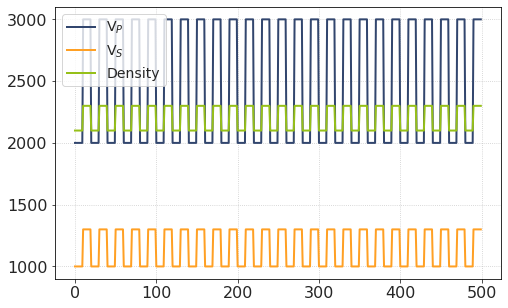

In [8]:
plt.plot(vp, label = 'V$_P$')
plt.plot(vs, label = 'V$_S$')
plt.plot(den, label = 'Density')
plt.legend()
plt.show()

In [9]:
out_Vp, out_Vs, out_den, out_ep, out_de, out_ga = Backus_avrg(vp, vs, den)
out_vpvs = out_Vp/out_Vs
out_eta = (out_ep-out_de)/(1+2*out_de)

In [10]:
print ('Vp0: \t {0:.1f}'.format(out_Vp))
print ('Vs0: \t {0:.1f}'.format(out_Vs))
print ('Density: {0:.0f}'.format(out_den))
print ('VpVs:\t {0:.3f}'.format(out_vpvs))

print ('Epsilon: {0:.3f}'.format(out_ep))
print ('Delta: \t {0:.3f}'.format(out_de))
print ('Gamma:\t {0:.3f}'.format(out_ga))
print ('Eta:\t {0:.3f}'.format(out_eta))

Vp0: 	 2330.7
Vs0: 	 1113.3
Density: 2200
VpVs:	 2.093
Epsilon: 0.054
Delta: 	 0.019
Gamma:	 0.049
Eta:	 0.034


As we can see, this synthetic rock is anisotropic ($\varepsilon$ and $\gamma$ are near 5%, $\delta$ is 2%). This effective anisotropy is caused by fine-layering. However, we remember that the layers themselves have no anisotropy at all.

V<sub>P0</sub> and V<sub>S0</sub> are lower than the arithmetic mean.

To analyze which elastic parameters control the anisotropy values (and how), we will proceed to stochastical modelling.

## Monte-Carlo Simulations 🎲

### Isotropic layers 🟦

In this section we are going to reproduce the results of [[Berryman, Grechka, 1997]](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.6.6858&rep=rep1&type=pdf) *(or [[Berryman, Grechka, 1999]](https://doi.org/10.1046/j.1365-2478.1999.00163.x), I don't know which source is better to cite)*

This simulation will, same as above, assume a model of two inter-layering rock types. Vp and Vs of each layer are random numbers uniformly distributed between specified boudaries. Density is constant (as it doesn't influence the anisotropy). No intrinsic anisotropy is incorporated.

We will use exactly the same model parameters as suggested in the mentioned paper. This will allow us to compare the results and expect them to be similar.

* Vp [m/s]: min = 2500, max = 5500 
* Vs/Vp: min = 0.35, max = 0.65
* Density [kg/m<sup>3</sup>]: 2670
* Number of models: 500

The results will not depend on the number of layers in the model (as long as total thicknesses of both rock types are the same). Thus we do not need to have many layers: two will suffice.

In [11]:
vpmin = 2500
vpmax = 5500
rmin = 0.35 # r is Vs/Vp
rmax = 0.65
density = 2670

Nmodels = 500

vp1 = np.random.rand(Nmodels)*(vpmax - vpmin) + vpmin
vp2 = np.random.rand(Nmodels)*(vpmax - vpmin) + vpmin

r1 = np.random.rand(Nmodels)*(rmax - rmin) + rmin
r2 = np.random.rand(Nmodels)*(rmax - rmin) + rmin

vs1 = vp1*r1
vs2 = vp2*r2


In [12]:
out_Vp = np.zeros(Nmodels)
out_Vs = np.zeros(Nmodels)
out_den = np.zeros(Nmodels)
out_ep = np.zeros(Nmodels)
out_de = np.zeros(Nmodels)
out_ga = np.zeros(Nmodels)
out_vpvs = np.zeros(Nmodels)

for i in range(Nmodels):

    vp = np.array((vp1[i], vp2[i]))
    vs = np.array((vs1[i], vs2[i]))
    den = np.array((density, density))

    out_Vp[i], out_Vs[i], out_den[i], out_ep[i], out_de[i], out_ga[i] = Backus_avrg(vp, vs, den)
    
out_eta = (out_ep-out_de)/(1+2*out_de)
out_vpvs = out_Vp/out_Vs

Now that we have computed the synthetic models and averaged them, it's time to plot and analyze the results.


To me, it's always fun to obtain the results that are similar to those of famous scientists. Here we have a wonderful opportunity to recreate cross-plots between Thomsen parameters from [Berryman, Grechka, 1997](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.6.6858&rep=rep1&type=pdf)

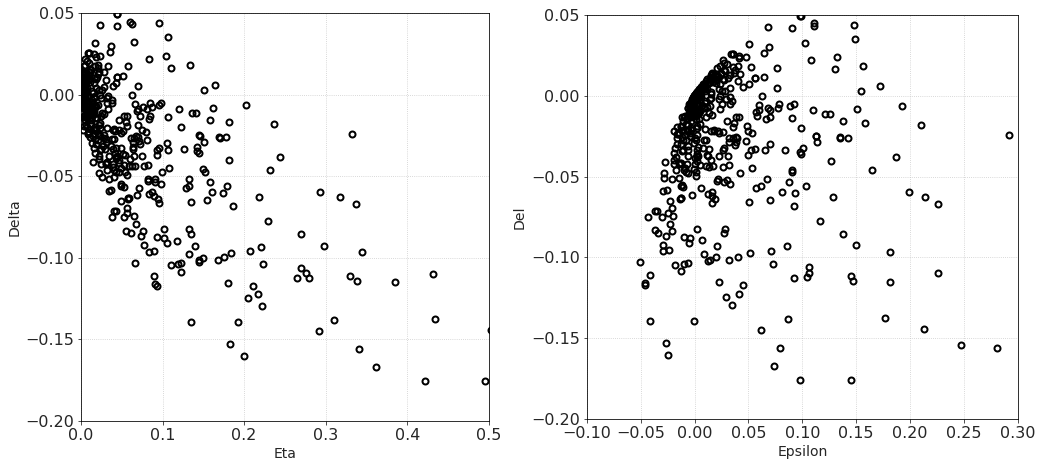

In [13]:
f,ax = plt.subplots(1,2,figsize = [17,7.5])

ax[0].plot(out_eta, out_de, mfc = 'none', mec = 'k', ms = 6, mew = 2, lw = 0, marker = 'o')
ax[1].plot(out_ep, out_de, mfc = 'none', mec = 'k', ms = 6, mew = 2, lw = 0, marker = 'o')


ax[0].set_xlim([0, 0.5])
ax[0].set_ylim([-0.2, 0.05])
ax[0].set_aspect(2)
ax[0].set_xlabel('Eta')
ax[0].set_ylabel('Delta')

ax[1].set_xlim([-0.1, 0.3])
ax[1].set_ylim([-0.2, 0.05])
ax[1].set_xlabel('Epsilon')
ax[1].set_ylabel('Del')
ax[1].set_aspect(1.5)

plt.show()

These crossplots are really quite similar to the figures from the paper of Berryman and Grechka (shown below).

| Delta vs Eta  | Delta vs Epsilon |
|:-------------------------:|:-------------------------:|
|![](./Images/Backus_pap_de_vs_eta.png) | ![](./Images/Backus_pap_de_vs_ep.png)|


How about the other anisotropic parameters and their relationships? Let's use the power of [`seaborn`](https://seaborn.pydata.org/) library and make pair-wise crossplots.

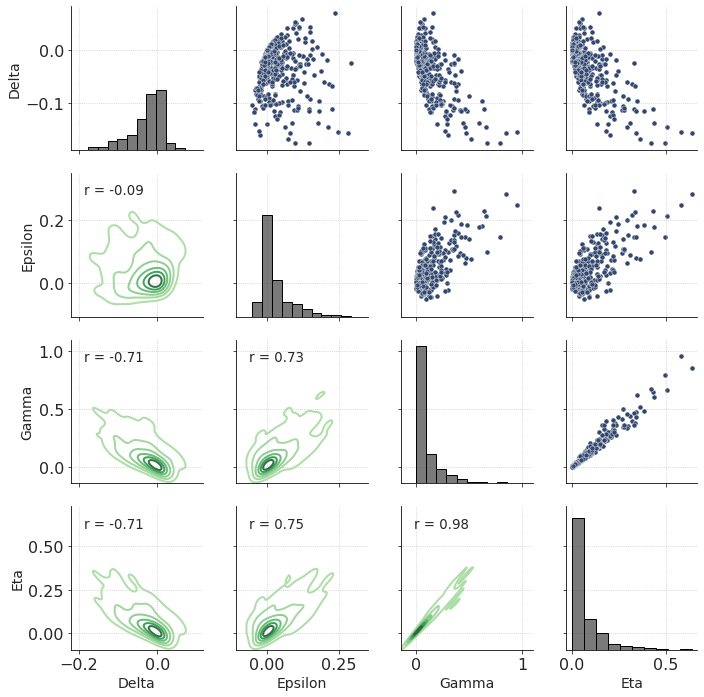

In [14]:
import seaborn as sns
import pandas as pd
from scipy import stats

labels_aniso = ['Delta', 'Epsilon', 'Gamma', 'Eta']

df_model1 = pd.DataFrame(np.column_stack([out_de, out_ep, out_ga, out_eta]), columns = labels_aniso)

g = sns.PairGrid(df_model1)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, levels = 7, cmap="Greens_d")
g.map_diag(sns.histplot, color = ".3", bins = 10)


def corrfunc(x, y, **kws):
    """
    https://stackoverflow.com/a/30942817/5819875
    """
    
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .85), xycoords=ax.transAxes, fontsize = 'small')

g.map_lower(corrfunc)
plt.show()

Note a certain, almost linear, relationship between Eta and Gamma.

What causes this anisotropy and influences its degree? It seems rather obvious that the stronger the contrast between layers, the higher the anisotropy. However, which elastic parameter is most important? Crossplots between anisotropy parameters and elatic contrasts may shed some light on it.

Below is the grid of relationships between {𝜀, 𝛿, 𝛾, 𝜂} and absolute values of {ΔV<sub>P</sub>, ΔV<sub>S</sub>, Δ(V<sub>P</sub>/V<sub>S</sub>)}. 

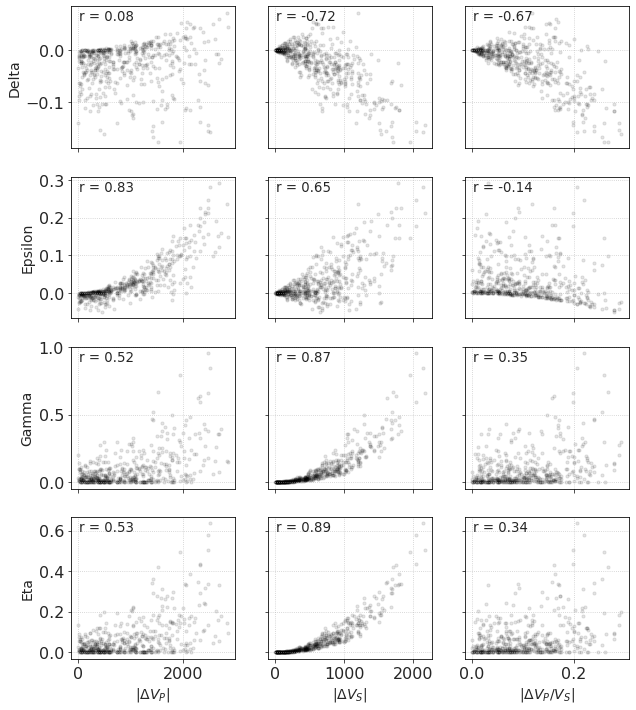

In [15]:
f, ax =  plt.subplots(4,3, figsize = [10,12], sharex = 'col', sharey = 'row')

labels_contrast = ['$|\Delta V_P|$', '$|\Delta V_S|$', '$|\Delta V_P/V_S|$']

for i, aniso_param in enumerate([out_de, out_ep, out_ga, out_eta]):
    for j, model_contrast in enumerate([np.abs(vp1 - vp2), np.abs(vs1 - vs2), np.abs(r1 - r2)]):
        q = ax[i][j].scatter(model_contrast, aniso_param, s = 10, c = 'k', alpha = 0.1)
        r, _ = stats.pearsonr(model_contrast, aniso_param)
        ax[i][j].annotate("r = {:.2f}".format(r),
                           xy=(.05, .9), xycoords=ax[i][j].transAxes, fontsize = 'small')
        
[ax[i][0].set_ylabel(labels_aniso[i]) for i in range(ax.shape[0])]
[ax[ax.shape[0]-1][j].set_xlabel(labels_contrast[j]) for j in range(ax.shape[1])]

plt.show()

The strongest correlation is between:
- 𝜀 and ΔV<sub>P</sub>,
- 𝛾 and ΔV<sub>S</sub>, 
- 𝜂 and ΔV<sub>S</sub>. 

Strangely, on '𝜀 - ΔV<sub>P</sub>/V<sub>S</sub>' and '𝛿 - ΔV<sub>P</sub>' crossplot there are darker lines of higher point density but there are lots of outliers as well.

### Anisotropic layers ↗️

If the thin layers are intrinsically anisotropic, it additionally amplifies the total anisotropy of the effective medium.

Let us add random values of Thomsen parameters to the layers of the above model.

* $\varepsilon$: min = 0, max = 0.1
* $\delta$: min = -0.1, max = 0.025
* $\gamma$: min = 0, max = 0.1


In [16]:
ep_min = 0
ep_max = 0.1
de_min = -0.1
de_max = 0.025
ga_min = 0
ga_max = 0.1

ep1 = np.random.rand(Nmodels)*(ep_max - ep_min) + ep_min
ep2 = np.zeros(Nmodels)

de1 = np.random.rand(Nmodels)*(de_max - de_min) + de_min
de2 = np.zeros(Nmodels)

ga1 = np.random.rand(Nmodels)*(ga_max - ga_min) + ga_min
ga2 = np.zeros(Nmodels)

eta1 = (ep1-de1)/(1+2*de1)

eta_min = 0
eta_max = 0.2

density = 2670

In [17]:
out_Vp = np.zeros(Nmodels)
out_Vs = np.zeros(Nmodels)
out_ep = np.zeros(Nmodels)
out_de = np.zeros(Nmodels)
out_ga = np.zeros(Nmodels)
out_vpvs = np.zeros(Nmodels)

for i in range(Nmodels):

    vp = np.array((vp1[i], vp2[i]))
    vs = np.array((vs1[i], vs2[i]))
    den = np.array((density, density))
    ep = np.array((ep1[i], ep2[i]))
    de = np.array((de1[i], de2[i]))
    ga = np.array((ga1[i], ga2[i]))

    out_Vp[i], out_Vs[i], out_den[i], out_ep[i], out_de[i], out_ga[i] = Backus_avrg(vp, vs, den, ep, de, ga)
    
out_eta = (out_ep-out_de)/(1+2*out_de)
out_vpvs = out_Vp/out_Vs

Same as before, let's plot anisotropy parameters against elastic contrasts, coding intrinsic anisotropy in color. 

E:\Python27\Anaconda\envs\Bookenv\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  if sys.path[0] == '':


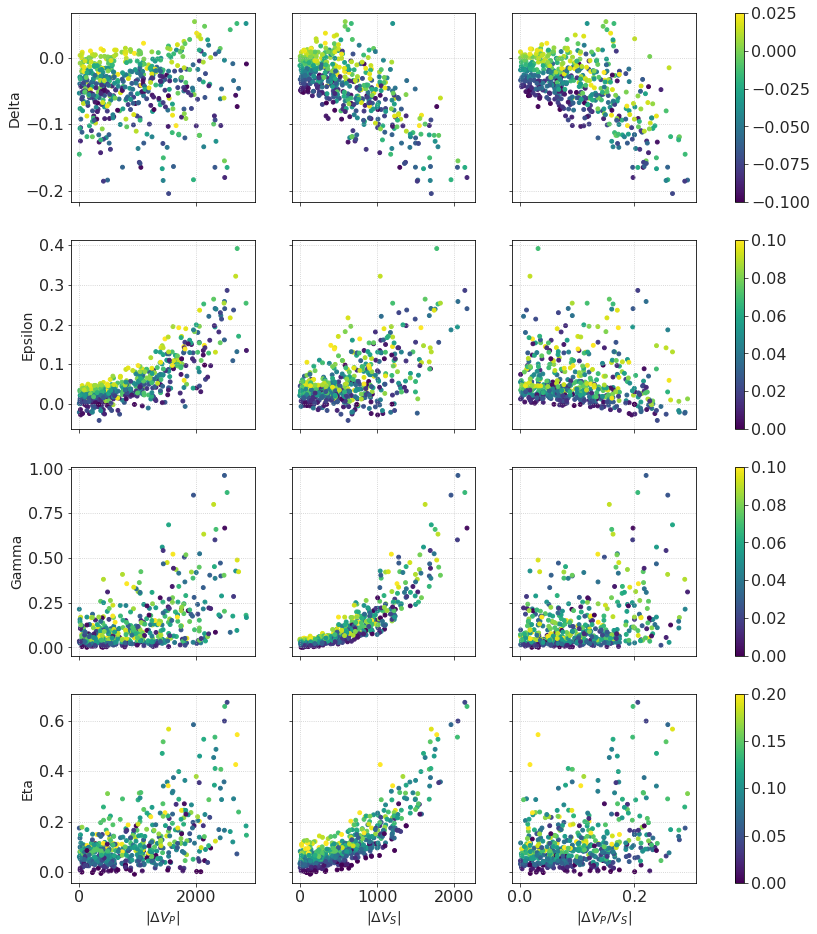

In [18]:
f, ax =  plt.subplots(4,3, figsize = [14,16], sharex = 'col', sharey = 'row')

intrinsic_params = [de1, ep1, ga1, eta1]
min_c_vals = [de_min, ep_min, ga_min, eta_min]
max_c_vals = [de_max, ep_max, ga_max, eta_max]
labels_aniso = ['Delta', 'Epsilon', 'Gamma', 'Eta']
labels_contrast = ['$|\Delta V_P|$', '$|\Delta V_S|$', '$|\Delta V_P/V_S|$']

for i, aniso_param in enumerate([out_de, out_ep, out_ga, out_eta]):
    for j, model_contrast in enumerate([np.abs(vp1 - vp2), np.abs(vs1 - vs2), np.abs(r1 - r2)]):
        q = ax[i][j].scatter(model_contrast, aniso_param, s = 15, cmap = 'viridis', c = intrinsic_params[i], vmin = min_c_vals[i], vmax = max_c_vals[i])
    f.colorbar(q, ax=ax[i].tolist())
        
[ax[i][0].set_ylabel(labels_aniso[i]) for i in range(ax.shape[0])]
[ax[ax.shape[0]-1][j].set_xlabel(labels_contrast[j]) for j in range(ax.shape[1])]

plt.show()

These points are colored by their corresponding intrinsic anisotropy parameters;

Same as before, we observe a strong positive correlation between effective $\gamma$  and ΔV<sub>S</sub>, effective $ \varepsilon $ and ΔV<sub>P</sub>.

Generally, the more 'anisotropic' layers are, the more anisotropic is the effective medium. Numerically this is expressed with an equation which can be found, for example, in [[Thomsen, 2002]](https://library.seg.org/doi/pdf/10.1190/1.9781560801986). We see that the yellow points (which correspond to higher intrinsic anisotropy) are situated in regions of higher effective anisotropy.

## Log data and rolling window averaging 🪵

Backus averaging can be applied within a rolling window to a well log (a set of logs). 

Vp, Vs, density and anisotropy (if available) log curves are used as an input.

Upscaled logs are output.

For this example, we will use well logs from [Penobscot dataset](https://terranubis.com/datainfo/Penobscot). Unfortunately these data lack V<sub>S</sub> measurements, so we will have to estimate it from P-wave velocity using a linear Castagna equation.

### Data import

In [19]:
data = np.loadtxt(r'./Data/w4_las_1500_2500m.txt', skiprows = 1)

In [20]:
dpt_w4 = data[:, 0]
vp_w4 = data[:, 1]
den_w4 = data[:, 2]
Nsamples = len(dpt_w4)

Now we aregoing to synthesize a V<sub>S</sub> curve. However, we will modify the equation coefficients within two arbitrary depth intervals to obtain higher variability in Vp/Vs.

In [21]:
vs_w4 = (vp_w4 - 1360)/(1.16) #castagna equation https://doi.org/10.1190%2F1.1441933

# modify equation constants for a specific interval
vs_w4[(dpt_w4>2030) & (dpt_w4<2200)] = (vp_w4[(dpt_w4>2030) & (dpt_w4<2200)] - 1260)/1.12
vs_w4[dpt_w4>2400] = (vp_w4[dpt_w4>2400] - 1460)/1.2

vpvs_w4 = vp_w4/vs_w4

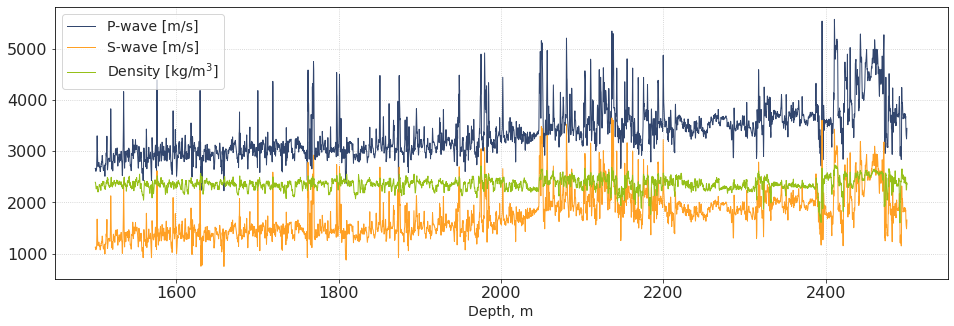

In [22]:
plt.subplots(figsize = [16,5])
plt.plot(dpt_w4, vp_w4, lw = 1, label = 'P-wave [m/s]')
plt.plot(dpt_w4, vs_w4, lw = 1, label = 'S-wave [m/s]')
plt.plot(dpt_w4, den_w4, lw = 1, label = 'Density [kg/m$^3$]')
plt.xlabel('Depth, m')
plt.legend()
plt.show()

E:\Python27\Anaconda\envs\Bookenv\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  after removing the cwd from sys.path.


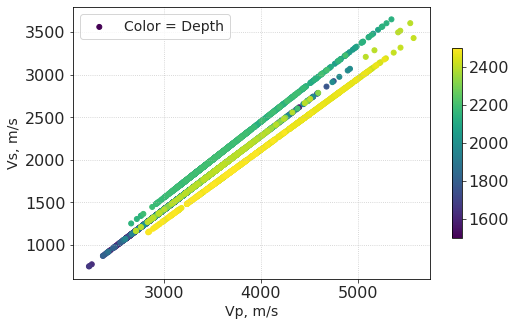

In [23]:
plt.scatter(vp_w4, vs_w4, c = dpt_w4, label = 'Color = Depth')
plt.xlabel('Vp, m/s')
plt.ylabel('Vs, m/s')
plt.colorbar(shrink= 0.7)
plt.legend()
plt.show()

### Averaging window

Selection of averaging window length is not straightforward; however, Liner and Fei [have shown](https://library.seg.org/doi/abs/10.1190/1.2723204) that optimal window length should be chosen regarding signal frequency and S-wave velocity. They proposed a parameter $B$ which is dependent on frequency $f$, averaging length $L'$ and S-wave velocity $V_{S0}$ (after averaging):

$$
B \equiv \frac{fL'} {\min(V_{S0})} \leq 
\begin{cases}
       1/3 & \text{scattering limit}\\
       2 &\text{transmission limit}
  \end{cases}   
$$

(so-called 'Backus number').


Suppose the seismic record has a dominant frequency of 30 Hz. For the most of the log, V<sub>S</sub> is 1500 m/s or higher. 
Then if we choose a 40 m window, Backus number $B$ is less than 1 which keeps us below the 'transmission limit'. 

That means that the averaged anisotropy and velocity are accurate enough for traveltime computations.

In [24]:
# define averaging window
rolling_window_len_m = 40

# How many samples fit into the averaging window 
rolling_window_len_samples = int(rolling_window_len_m/(np.median(np.diff(dpt_w4)))) #step is 0.5 ft (0.15 or 0.16 m)

### Results

In [25]:
out_Vp = np.zeros_like(dpt_w4)
out_Vs = np.zeros_like(dpt_w4)
out_den = np.zeros_like(dpt_w4)
out_ep = np.zeros_like(dpt_w4)
out_de = np.zeros_like(dpt_w4)
out_ga = np.zeros_like(dpt_w4)

In [26]:
for i in range(len(dpt_w4)):
    window_start = np.max((0, i-rolling_window_len_samples//2))
    window_end = np.min((len(dpt_w4), i+rolling_window_len_samples//2))

    vp = vp_w4[window_start:window_end]
    vs = vs_w4[window_start:window_end]
    den = den_w4[window_start:window_end]

    out_Vp[i], out_Vs[i], out_den[i], out_ep[i], out_de[i], out_ga[i] = Backus_avrg(vp, vs, den)
    
out_eta = (out_ep-out_de)/(1+2*out_de)
out_vpvs = out_Vp/out_Vs

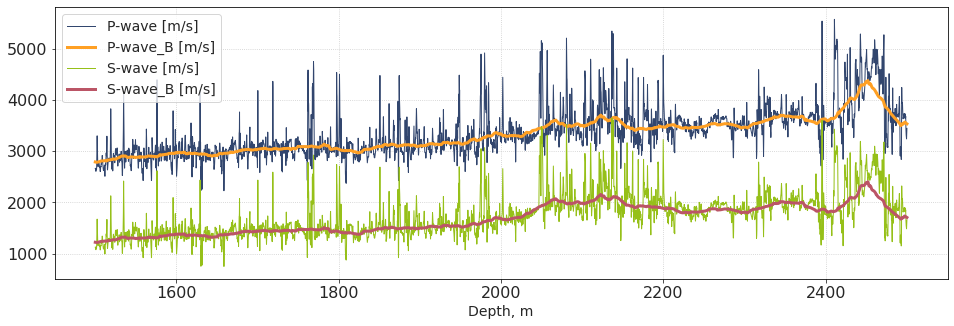

In [27]:
plt.subplots(figsize = [16,5])
plt.plot(dpt_w4, vp_w4, lw = 1, label = 'P-wave [m/s]')
plt.plot(dpt_w4, out_Vp, lw = 3, label = 'P-wave_B [m/s]')
plt.plot(dpt_w4, vs_w4, lw = 1, label = 'S-wave [m/s]')
plt.plot(dpt_w4, out_Vs, lw = 3, label = 'S-wave_B [m/s]')

plt.xlabel('Depth, m')
plt.legend()
plt.show()

We see that the averaged velocities are indeed a smooth version of input logs. How about anisotropy?

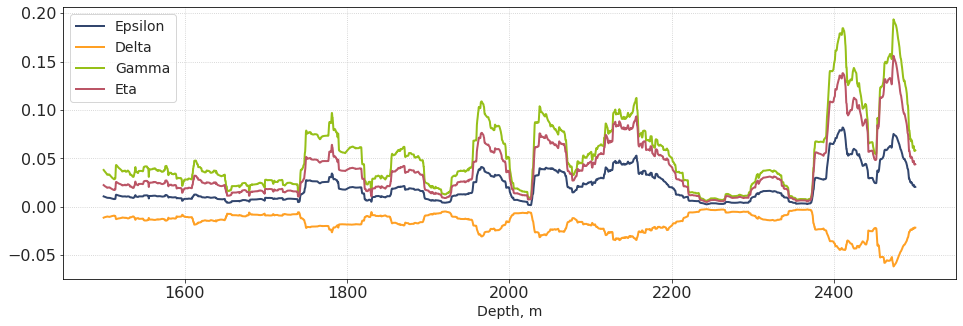

In [28]:
plt.subplots(figsize = [16,5])
plt.plot(dpt_w4, out_ep, lw = 2, label = 'Epsilon')
plt.plot(dpt_w4, out_de, lw = 2, label = 'Delta')
plt.plot(dpt_w4, out_ga, lw = 2, label = 'Gamma')
plt.plot(dpt_w4, out_eta, lw = 2, label = 'Eta')

plt.xlabel('Depth, m')
plt.legend()
plt.show()

These are the effective anisotropy logs (upscaled to roughly seismic bandwidth). Unfortunately, since Vp and Vs are perfectly correlated, the anisotropy parameters are strongly correlated, too.

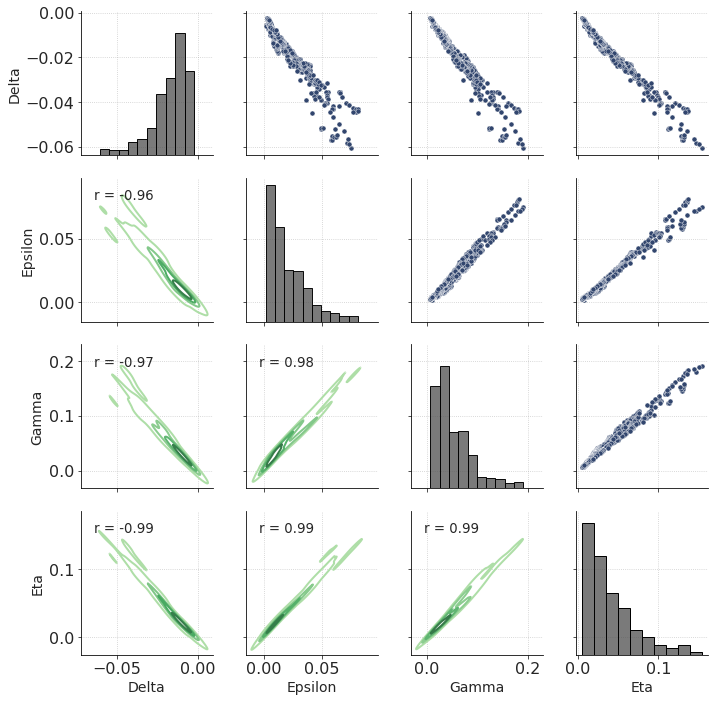

In [29]:
df_w4 = pd.DataFrame(np.column_stack([out_de, out_ep, out_ga, out_eta]), columns = labels_aniso)

g = sns.PairGrid(df_w4.iloc[::10]) # only include every 10th point in cross-plotting
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, levels = 5, cmap="Greens_d")
g.map_diag(sns.histplot, color = ".3", bins = 10)

def corrfunc(x, y, **kws):
    """
    https://stackoverflow.com/a/30942817/5819875
    """
    
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .85), xycoords=ax.transAxes, fontsize = 'small')

g.map_lower(corrfunc)
plt.show()

## Conclusion 🏁

* Backus averaging allows to estimate the anisotropy of a layered rock;
* Thomsen parameters of a layered rock are not independent;
* Effective 𝜀 of a layered rock depends mostly on V<sub>P</sub> contrast, while effective 𝛾 and 𝜂 correlate to V<sub>S</sub> contrast;
* Applying Backus averaging in a rolling window allows to upscale the well logs (to match the seismic resolution) and compute the effective anisotropy

## Related topics 🔗

- VTI anisotropy

___
<sub>Created on May 13, 2022</sub> / 
<sub>Modified on Aug 17, 2022</sub>